In [1]:
# importing data manipulation libraries
import pandas as pd
import numpy as np

# from ydata_profiling import ProfileReport

# importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# import ML tools 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


# configure notebook for inline plotting
%matplotlib inline

# config pandas to display more than 20 columns
pd.set_option('display.max_columns',250)

# set grid style 
sns.set_style('darkgrid')

In [2]:
# load data from file
data = pd.read_csv('./data/match_data_avg_stats.csv', header=0)

# inspect the dataframe
data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,team_a_xg_prematch,team_b_xg_prematch,total_xg_prematch,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away
0,2155,150,108,Hull City,Leicester City,2016-08-13,2016/2017,complete,2,1,3,2,2,3.41,3.19,2.39,1.47,0.53,0.0,0.0,0.0,1.053772,1.976917,1.107030,1.128482,1.053772,1.773939,1.056286,1.026993,3.933333,6.333333,7.200000,8.533333,0.866667,1.733333,1.2,0.666667,1.386147,1.923433,-0.002514,0.746946,280.333333,238.133333,20.133333,25.733333,185.066667,168.266667,20.933333,22.666667
1,2156,145,154,Burnley,Swansea City,2016-08-13,2016/2017,complete,0,1,1,3,2,2.45,3.22,3.26,1.74,0.74,0.0,0.0,0.0,0.982456,1.125890,1.571102,1.606961,0.931711,1.125890,1.418868,1.606961,5.733333,5.733333,6.666667,7.400000,0.466667,1.333333,1.0,1.400000,0.958993,1.077167,-0.487157,-0.481071,274.466667,217.933333,23.600000,28.000000,179.533333,256.466667,20.266667,26.333333
2,2157,143,142,Crystal Palace,West Bromwich Albion,2016-08-13,2016/2017,complete,0,1,1,2,2,2.20,3.25,3.80,1.05,0.84,0.0,0.0,0.0,1.111550,1.211611,1.430625,1.335043,1.060806,1.058202,1.278391,1.284298,3.733333,4.466667,8.733333,7.800000,1.000000,0.800000,1.6,1.200000,1.137407,1.299807,-0.217585,-0.226096,208.266667,260.933333,23.866667,24.466667,182.666667,137.866667,24.866667,21.866667
3,2158,144,92,Everton,Tottenham Hotspur,2016-08-13,2016/2017,complete,1,1,2,0,0,3.13,3.36,2.45,2.26,1.74,0.0,0.0,0.0,1.469059,1.948587,1.613283,1.014782,1.215339,1.847100,1.511794,0.964038,6.466667,7.333333,9.666667,4.733333,1.266667,1.866667,1.4,1.066667,1.350113,2.020447,-0.296455,0.883062,208.533333,169.133333,21.800000,26.600000,250.666667,270.600000,24.800000,24.266667
4,2159,147,141,Middlesbrough,Stoke City,2016-08-13,2016/2017,complete,1,1,2,3,5,2.49,3.20,3.21,0.95,0.89,0.0,0.0,0.0,NaN,0.959606,NaN,1.577794,NaN,0.908862,NaN,1.425562,NaN,5.733333,NaN,6.266667,NaN,1.133333,NaN,2.000000,NaN,1.061133,NaN,-0.516701,NaN,221.800000,NaN,22.866667,NaN,241.000000,NaN,25.066667


In [3]:
# drop matches with "incomplete" or "suspended" status
data = data[data['status'] == 'complete']

In [4]:
# check shape of data
data.shape

(6278, 49)

In [5]:
# Get the shape (number of rows and columns) where the 'team_a_xg_prematch' column is equal to 0
data[data['team_a_xg_prematch']==0].shape

(3609, 49)

In [6]:
# Get the shape (number of rows and columns) where the 'team_b_xg_prematch' column is equal to 0
data[data['team_b_xg_prematch']==0].shape

(3609, 49)

In [7]:
# Get the shape (number of rows and columns) where the 'total_xg_prematch' column is equal to 0
data[data['total_xg_prematch']==0].shape

(3603, 49)

In [8]:
# inspect the first few rows of data dataframe
data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,team_a_xg_prematch,team_b_xg_prematch,total_xg_prematch,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away
0,2155,150,108,Hull City,Leicester City,2016-08-13,2016/2017,complete,2,1,3,2,2,3.41,3.19,2.39,1.47,0.53,0.0,0.0,0.0,1.053772,1.976917,1.107030,1.128482,1.053772,1.773939,1.056286,1.026993,3.933333,6.333333,7.200000,8.533333,0.866667,1.733333,1.2,0.666667,1.386147,1.923433,-0.002514,0.746946,280.333333,238.133333,20.133333,25.733333,185.066667,168.266667,20.933333,22.666667
1,2156,145,154,Burnley,Swansea City,2016-08-13,2016/2017,complete,0,1,1,3,2,2.45,3.22,3.26,1.74,0.74,0.0,0.0,0.0,0.982456,1.125890,1.571102,1.606961,0.931711,1.125890,1.418868,1.606961,5.733333,5.733333,6.666667,7.400000,0.466667,1.333333,1.0,1.400000,0.958993,1.077167,-0.487157,-0.481071,274.466667,217.933333,23.600000,28.000000,179.533333,256.466667,20.266667,26.333333
2,2157,143,142,Crystal Palace,West Bromwich Albion,2016-08-13,2016/2017,complete,0,1,1,2,2,2.20,3.25,3.80,1.05,0.84,0.0,0.0,0.0,1.111550,1.211611,1.430625,1.335043,1.060806,1.058202,1.278391,1.284298,3.733333,4.466667,8.733333,7.800000,1.000000,0.800000,1.6,1.200000,1.137407,1.299807,-0.217585,-0.226096,208.266667,260.933333,23.866667,24.466667,182.666667,137.866667,24.866667,21.866667
3,2158,144,92,Everton,Tottenham Hotspur,2016-08-13,2016/2017,complete,1,1,2,0,0,3.13,3.36,2.45,2.26,1.74,0.0,0.0,0.0,1.469059,1.948587,1.613283,1.014782,1.215339,1.847100,1.511794,0.964038,6.466667,7.333333,9.666667,4.733333,1.266667,1.866667,1.4,1.066667,1.350113,2.020447,-0.296455,0.883062,208.533333,169.133333,21.800000,26.600000,250.666667,270.600000,24.800000,24.266667
4,2159,147,141,Middlesbrough,Stoke City,2016-08-13,2016/2017,complete,1,1,2,3,5,2.49,3.20,3.21,0.95,0.89,0.0,0.0,0.0,NaN,0.959606,NaN,1.577794,NaN,0.908862,NaN,1.425562,NaN,5.733333,NaN,6.266667,NaN,1.133333,NaN,2.000000,NaN,1.061133,NaN,-0.516701,NaN,221.800000,NaN,22.866667,NaN,241.000000,NaN,25.066667


In [9]:
def winningTeam(row):
    # Extracting the goal counts for the home and away teams from the row
    homeGoalCount = row['homeGoalCount']
    awayGoalCount = row['awayGoalCount']
    
    # Checking which team won based on the goal counts
    if homeGoalCount > awayGoalCount:
        return 1  # 1 means home team won
    elif awayGoalCount > homeGoalCount:
        return 2  # 2 means away team won
    else:
        return 0  # 0 indicates a draw


In [10]:
# Apply the winningTeam function to each row of the dataframe
data['1x2'] = data.apply(lambda row: winningTeam(row), axis=1)

In [11]:
# check for missing values in the ppg columns
data[data['away_ppg']==0].shape

(0, 50)

In [12]:
data[data['odds_ft_1']==0].shape

(1915, 50)

In [13]:
# check shape of dataframe 
data.shape

(6278, 50)

In [14]:
# drop entries where odds is zero
cleaned_data = data.drop(index=data[data['odds_ft_1']==0].index)

In [15]:
# check size of new dataframe
cleaned_data.shape

(4363, 50)

In [16]:
# inspect column to check that entries with zeros have been dropped
cleaned_data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,team_a_xg_prematch,team_b_xg_prematch,total_xg_prematch,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away,1x2
0,2155,150,108,Hull City,Leicester City,2016-08-13,2016/2017,complete,2,1,3,2,2,3.41,3.19,2.39,1.47,0.53,0.0,0.0,0.0,1.053772,1.976917,1.107030,1.128482,1.053772,1.773939,1.056286,1.026993,3.933333,6.333333,7.200000,8.533333,0.866667,1.733333,1.2,0.666667,1.386147,1.923433,-0.002514,0.746946,280.333333,238.133333,20.133333,25.733333,185.066667,168.266667,20.933333,22.666667,1
1,2156,145,154,Burnley,Swansea City,2016-08-13,2016/2017,complete,0,1,1,3,2,2.45,3.22,3.26,1.74,0.74,0.0,0.0,0.0,0.982456,1.125890,1.571102,1.606961,0.931711,1.125890,1.418868,1.606961,5.733333,5.733333,6.666667,7.400000,0.466667,1.333333,1.0,1.400000,0.958993,1.077167,-0.487157,-0.481071,274.466667,217.933333,23.600000,28.000000,179.533333,256.466667,20.266667,26.333333,2
2,2157,143,142,Crystal Palace,West Bromwich Albion,2016-08-13,2016/2017,complete,0,1,1,2,2,2.20,3.25,3.80,1.05,0.84,0.0,0.0,0.0,1.111550,1.211611,1.430625,1.335043,1.060806,1.058202,1.278391,1.284298,3.733333,4.466667,8.733333,7.800000,1.000000,0.800000,1.6,1.200000,1.137407,1.299807,-0.217585,-0.226096,208.266667,260.933333,23.866667,24.466667,182.666667,137.866667,24.866667,21.866667,2
3,2158,144,92,Everton,Tottenham Hotspur,2016-08-13,2016/2017,complete,1,1,2,0,0,3.13,3.36,2.45,2.26,1.74,0.0,0.0,0.0,1.469059,1.948587,1.613283,1.014782,1.215339,1.847100,1.511794,0.964038,6.466667,7.333333,9.666667,4.733333,1.266667,1.866667,1.4,1.066667,1.350113,2.020447,-0.296455,0.883062,208.533333,169.133333,21.800000,26.600000,250.666667,270.600000,24.800000,24.266667,0
4,2159,147,141,Middlesbrough,Stoke City,2016-08-13,2016/2017,complete,1,1,2,3,5,2.49,3.20,3.21,0.95,0.89,0.0,0.0,0.0,NaN,0.959606,NaN,1.577794,NaN,0.908862,NaN,1.425562,NaN,5.733333,NaN,6.266667,NaN,1.133333,NaN,2.000000,NaN,1.061133,NaN,-0.516701,NaN,221.800000,NaN,22.866667,NaN,241.000000,NaN,25.066667,0


In [17]:
# get dataframe info
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4363 entries, 0 to 6279
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4363 non-null   int64  
 1   homeID                 4363 non-null   int64  
 2   awayID                 4363 non-null   int64  
 3   home_name              4363 non-null   object 
 4   away_name              4363 non-null   object 
 5   date                   4363 non-null   object 
 6   season                 4363 non-null   object 
 7   status                 4363 non-null   object 
 8   homeGoalCount          4363 non-null   int64  
 9   awayGoalCount          4363 non-null   int64  
 10  totalGoalCount         4363 non-null   int64  
 11  team_a_cards_num       4363 non-null   int64  
 12  team_b_cards_num       4363 non-null   int64  
 13  odds_ft_1              4363 non-null   float64
 14  odds_ft_x              4363 non-null   float64
 15  odds

In [18]:
# Define a list of columns to be dropped from the DataFrame
columns_to_drop = ['id', 'homeID', 'awayID', 'home_name', 'away_name', 'date', 'season','status']

# Drop the specified columns from the DataFrame
cleaned_data = cleaned_data.drop(columns=columns_to_drop)

In [19]:
# inspect cleaned dataset to confirm columns were dropped successfully
cleaned_data.head()

,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,team_a_xg_prematch,team_b_xg_prematch,total_xg_prematch,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away,1x2
0,2,1,3,2,2,3.41,3.19,2.39,1.47,0.53,0.0,0.0,0.0,1.053772,1.976917,1.107030,1.128482,1.053772,1.773939,1.056286,1.026993,3.933333,6.333333,7.200000,8.533333,0.866667,1.733333,1.2,0.666667,1.386147,1.923433,-0.002514,0.746946,280.333333,238.133333,20.133333,25.733333,185.066667,168.266667,20.933333,22.666667,1
1,0,1,1,3,2,2.45,3.22,3.26,1.74,0.74,0.0,0.0,0.0,0.982456,1.125890,1.571102,1.606961,0.931711,1.125890,1.418868,1.606961,5.733333,5.733333,6.666667,7.400000,0.466667,1.333333,1.0,1.400000,0.958993,1.077167,-0.487157,-0.481071,274.466667,217.933333,23.600000,28.000000,179.533333,256.466667,20.266667,26.333333,2
2,0,1,1,2,2,2.20,3.25,3.80,1.05,0.84,0.0,0.0,0.0,1.111550,1.211611,1.430625,1.335043,1.060806,1.058202,1.278391,1.284298,3.733333,4.466667,8.733333,7.800000,1.000000,0.800000,1.6,1.200000,1.137407,1.299807,-0.217585,-0.226096,208.266667,260.933333,23.866667,24.466667,182.666667,137.866667,24.866667,21.866667,2
3,1,1,2,0,0,3.13,3.36,2.45,2.26,1.74,0.0,0.0,0.0,1.469059,1.948587,1.613283,1.014782,1.215339,1.847100,1.511794,0.964038,6.466667,7.333333,9.666667,4.733333,1.266667,1.866667,1.4,1.066667,1.350113,2.020447,-0.296455,0.883062,208.533333,169.133333,21.800000,26.600000,250.666667,270.600000,24.800000,24.266667,0
4,1,1,2,3,5,2.49,3.20,3.21,0.95,0.89,0.0,0.0,0.0,NaN,0.959606,NaN,1.577794,NaN,0.908862,NaN,1.425562,NaN,5.733333,NaN,6.266667,NaN,1.133333,NaN,2.000000,NaN,1.061133,NaN,-0.516701,NaN,221.800000,NaN,22.866667,NaN,241.000000,NaN,25.066667,0


In [20]:
# check for null values
cleaned_data.isnull().sum()

homeGoalCount              0
awayGoalCount              0
totalGoalCount             0
team_a_cards_num           0
team_b_cards_num           0
odds_ft_1                  0
odds_ft_x                  0
odds_ft_2                  0
home_ppg                   0
away_ppg                   0
team_a_xg_prematch         0
team_b_xg_prematch         0
total_xg_prematch          0
xG_home                  659
xG_away                  774
xGA_home                 659
xGA_away                 774
npxG_home                659
npxG_away                774
npxGA_home               659
npxGA_away               774
deep_home                659
deep_away                774
deep_allowed_home        659
deep_allowed_away        774
scored_home              659
scored_away              774
missed_home              659
missed_away              774
xpts_home                659
xpts_away                774
npxGD_home               659
npxGD_away               774
ppda.att_home            659
ppda.att_away 

In [21]:
# drop null values
cleaned_data.dropna(inplace=True)

In [22]:
# check for null values
cleaned_data.isnull().sum()

homeGoalCount            0
awayGoalCount            0
totalGoalCount           0
team_a_cards_num         0
team_b_cards_num         0
odds_ft_1                0
odds_ft_x                0
odds_ft_2                0
home_ppg                 0
away_ppg                 0
team_a_xg_prematch       0
team_b_xg_prematch       0
total_xg_prematch        0
xG_home                  0
xG_away                  0
xGA_home                 0
xGA_away                 0
npxG_home                0
npxG_away                0
npxGA_home               0
npxGA_away               0
deep_home                0
deep_away                0
deep_allowed_home        0
deep_allowed_away        0
scored_home              0
scored_away              0
missed_home              0
missed_away              0
xpts_home                0
xpts_away                0
npxGD_home               0
npxGD_away               0
ppda.att_home            0
ppda.att_away            0
ppda.def_home            0
ppda.def_away            0
p

In [23]:
# check for null values
cleaned_data.shape

(3026, 42)

In [24]:
# Aggregating card counts
cleaned_data['total_cards'] = cleaned_data['team_a_cards_num'] + cleaned_data['team_b_cards_num']

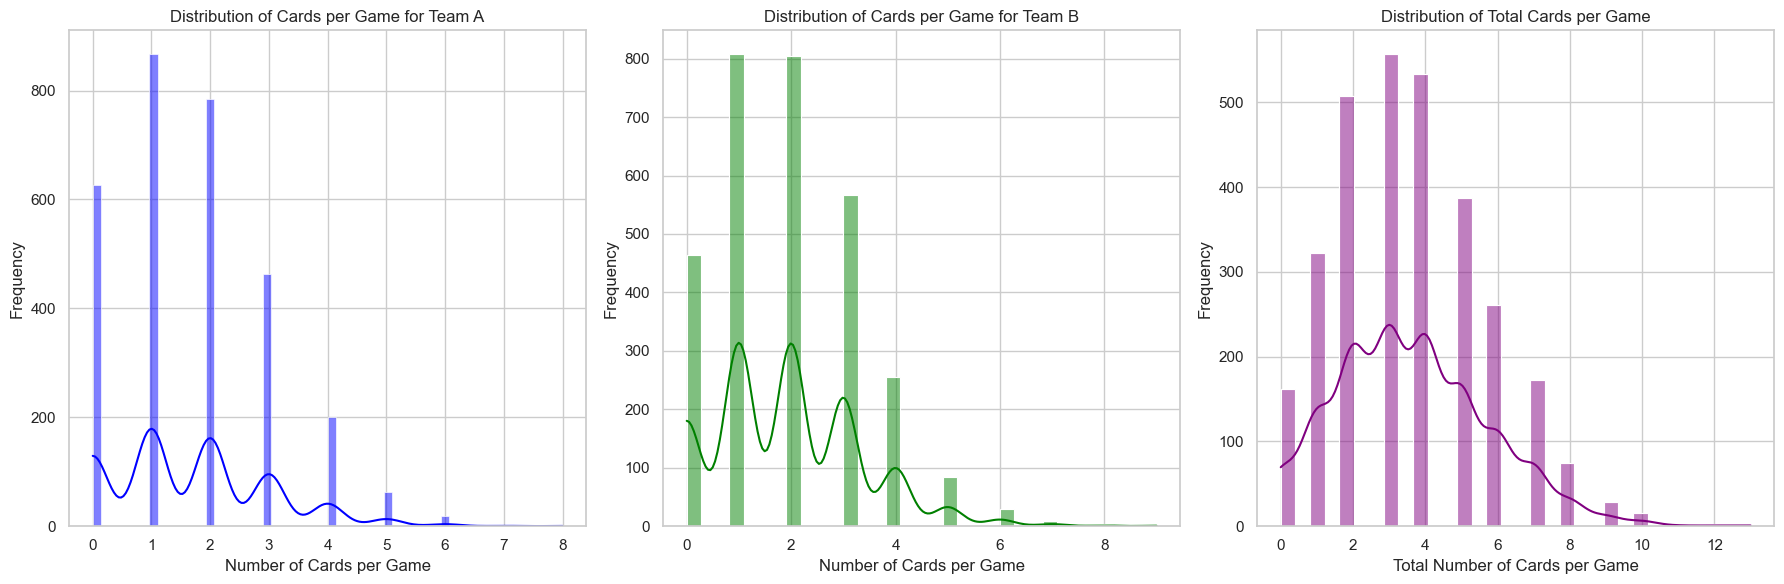

In [25]:
# Calculate the average number of cards per game for each team
cleaned_data['team_a_cards_per_game'] = cleaned_data['team_a_cards_num']
cleaned_data['team_b_cards_per_game'] = cleaned_data['team_b_cards_num']
cleaned_data['total_cards_per_game'] = cleaned_data['team_a_cards_per_game'] + cleaned_data['team_b_cards_per_game']

# Setting the style
sns.set(style="whitegrid")

# Creating a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting the distribution of average cards per game for Team A
sns.histplot(cleaned_data['team_a_cards_per_game'], ax=axes[0], kde=True, color='blue')
axes[0].set_title('Distribution of Cards per Game for Team A')
axes[0].set_xlabel('Number of Cards per Game')
axes[0].set_ylabel('Frequency')

# Plotting the distribution of average cards per game for Team B
sns.histplot(cleaned_data['team_b_cards_per_game'], ax=axes[1], kde=True, color='green')
axes[1].set_title('Distribution of Cards per Game for Team B')
axes[1].set_xlabel('Number of Cards per Game')
axes[1].set_ylabel('Frequency')

# Plotting the distribution of total cards per game
sns.histplot(cleaned_data['total_cards_per_game'], ax=axes[2], kde=True, color='purple')
axes[2].set_title('Distribution of Total Cards per Game')
axes[2].set_xlabel('Total Number of Cards per Game')
axes[2].set_ylabel('Frequency')

# Displaying the plot
plt.tight_layout()
plt.show()


Checking for Outliers

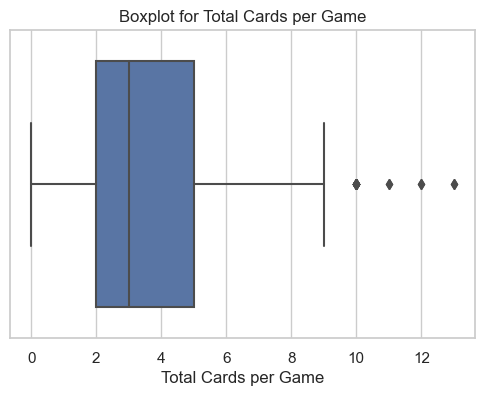

In [26]:
# Set the figure size for the boxplot
plt.figure(figsize=(6, 4))  

# Create a boxplot to visualize potential outliers
sns.boxplot(x=cleaned_data['total_cards_per_game'])
plt.title('Boxplot for Total Cards per Game')
plt.xlabel('Total Cards per Game')
# Show the plot
plt.show()

# Using the IQR method to detect numeric outliers (this does not produce a visual output)
Q1 = cleaned_data['total_cards_per_game'].quantile(0.25)
Q3 = cleaned_data['total_cards_per_game'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Finding any outliers 
outliers = cleaned_data[(cleaned_data['total_cards_per_game'] < lower_bound) | (cleaned_data['total_cards_per_game'] > upper_bound)]

In [27]:
# Using the IQR method to detect numeric outliers
Q1 = cleaned_data['total_cards_per_game'].quantile(0.25)
Q3 = cleaned_data['total_cards_per_game'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Overwrite the cleaned_data DataFrame by excluding the outliers
cleaned_data = cleaned_data[(cleaned_data['total_cards_per_game'] >= lower_bound) & (cleaned_data['total_cards_per_game'] <= upper_bound)]

# Verify the size of the cleaned DataFrame
print(f"DataFrame size after removing outliers: {cleaned_data.shape}")


DataFrame size after removing outliers: (3005, 46)


In the above code we dropped outliers as we noticed they were only 0.7% of our data and had an impact in our model.

#### Data Preprocessing

Splitting the dataset into features (X) and target variable (y)

In [28]:
from sklearn.tree import DecisionTreeRegressor


# Selecting a subset of features that might be relevant for predicting cards
features = [
    'home_ppg', 'away_ppg', 'odds_ft_1', 'odds_ft_x', 'odds_ft_2', 
    'homeGoalCount', 'awayGoalCount', 'totalGoalCount', 
    'team_a_xg_prematch', 'team_b_xg_prematch', 'total_xg_prematch'
]

# Preprocessing: Handling missing values by filling them with the mean
cleaned_data[features] = cleaned_data[features].fillna(cleaned_data[features].mean())

# Splitting the dataset into features (X) and target variable (y)
X = cleaned_data[features]
y = cleaned_data['total_cards']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Picking the most relevant features using : Recursive Feature Elimination

In [29]:
from sklearn.feature_selection import RFE

# Create the RFE object
rfe = RFE(estimator=RandomForestRegressor(random_state=42), n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

# Summarize selected features
selected_features = list(X_train.columns[rfe.support_])
print("Selected features:", selected_features)


Selected features: ['home_ppg', 'away_ppg', 'odds_ft_1', 'odds_ft_x', 'odds_ft_2', 'homeGoalCount', 'totalGoalCount', 'team_a_xg_prematch', 'team_b_xg_prematch', 'total_xg_prematch']


In [30]:
# Number of RFE selected features
rfe.n_features_


10

In [31]:
# Create the RFE object and rank each feature
rfe = RFE(estimator=RandomForestRegressor(random_state=42), n_features_to_select=10)
rfe.fit(X_train, y_train)

# Obtain the ranking for each feature
feature_ranking = rfe.ranking_

# Create a DataFrame to display feature names and their corresponding rankings
feature_ranking_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': feature_ranking
})

# Sort the DataFrame based on ranking
feature_ranking_df = feature_ranking_df.sort_values(by='Ranking')

# Display the feature rankings
print(feature_ranking_df)




               Feature  Ranking
0             home_ppg        1
1             away_ppg        1
2            odds_ft_1        1
3            odds_ft_x        1
4            odds_ft_2        1
5        homeGoalCount        1
7       totalGoalCount        1
8   team_a_xg_prematch        1
9   team_b_xg_prematch        1
10   total_xg_prematch        1
6        awayGoalCount        2


In [32]:
# Print the shape of the training feature set (X_train)
print('The shape of X_train is: ',X_train.shape)

The shape of X_train is:  (2404, 11)


Scaling

In [33]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Now, X_train_scaled and X_test_scaled are the scaled versions of your training and test sets


Baseline Model : Decision Tree Regressor

In [34]:
# Baseline Model: Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Training the model
dt_regressor.fit(X_train, y_train)

# Predicting on the test set
y_pred = dt_regressor.predict(X_test)
# Evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Cross-Validation for RMSE
cv_scores_rmse = cross_val_score(dt_regressor, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores_rmse)

# Cross-Validation for MAE
cv_scores_mae = cross_val_score(dt_regressor, X, y, cv=5, scoring='neg_mean_absolute_error')

# Cross-Validation for R-squared
cv_scores_r2 = cross_val_score(dt_regressor, X, y, cv=5, scoring='r2')

# Creating a dictionary for evaluation metrics
metrics_dict = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'R-squared'],
    'Test Set': [mse, rmse, mae, r2],
    'Cross-Validation Mean': [np.mean(-cv_scores_rmse), np.mean(cv_rmse_scores), np.mean(-cv_scores_mae), np.mean(cv_scores_r2)]
}

# Create a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(metrics_dict)

# Display the table
print(metrics_df)


      Metric  Test Set  Cross-Validation Mean
0        MSE  8.124792               8.310150
1       RMSE  2.850402               2.882304
2        MAE  2.231281               2.280200
3  R-squared -1.026572              -1.029859


The RMSE value of 2.88 indicates the prediction error, how much the predictions deviate from the actual values,which is about 2.88 units from our target variable's units (total cards per game).

In the next models we will work on improving this value.

LinearRegression

In [35]:
# Linear Regression model
linear_regressor = LinearRegression()

# Cross-validation
linear_cv_scores = cross_val_score(linear_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Training the model
linear_regressor.fit(X_train, y_train)

# Predicting on test set
y_pred_linear = linear_regressor.predict(X_test)

# Initialize the evaluation table as an empty DataFrame
evaluation_table = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'Mean CV Score (MSE)'])

# Evaluation
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)

# Append the linear regression results to the evaluation table
evaluation_table = evaluation_table.append({
    'Model': 'Linear Regression',
    'MSE': mse_linear,
    'RMSE': rmse_linear,
    'Mean CV Score (MSE)': -np.mean(linear_cv_scores)
}, ignore_index=True)

# Displaying the updated evaluation table
print(evaluation_table)


               Model       MSE      RMSE  Mean CV Score (MSE)
0  Linear Regression  3.963732  1.990912             4.053965


C:\Users\jmwan\AppData\Local\Temp\ipykernel_40568\1540992106.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_table = evaluation_table.append({


The RMSE value of 1.99 indicates an of error about 1.99 units from total cards per game.

Random Forest Regressor

In [36]:
# Random Forest model
rf_regressor = RandomForestRegressor(random_state=42)

# Cross-validation
rf_cv_scores = cross_val_score(rf_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Training the model
rf_regressor.fit(X_train, y_train)

# Predicting on test set
y_pred_rf = rf_regressor.predict(X_test)

# Evaluation
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

# Creating a dictionary to hold the evaluation metrics
evaluation_metrics = {
    'Model': ['Random Forest'],
    'MSE': [mse_rf],
    'RMSE': [rmse_rf],
    'Mean CV Score (MSE)': [-rf_cv_scores.mean()]
}

# Converting the dictionary into a DataFrame
evaluation_table = pd.DataFrame(evaluation_metrics)

# Displaying the evaluation table
print(evaluation_table)


           Model       MSE      RMSE  Mean CV Score (MSE)
0  Random Forest  4.175683  2.043449             4.218065


The RMSE value of 2.04 indicates an of error about 2.04 units from total cards per game.

Using variance_inflation_factor and Ridge Regression model to handle multicollinearity

In [37]:
# Definining our features and target variable
target = 'total_cards' 
features = cleaned_data.drop(columns=[target]).columns  

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Filtering out features with high VIF values
high_vif_features = vif_data[vif_data['VIF'] > 5]['feature']
reduced_X = X.drop(columns=high_vif_features)

# Ridge Regression model to handle multicollinearity
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred_ridge = ridge_reg.predict(X_test)

# Evaluation
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)

# Creating a dictionary to hold the evaluation metrics
evaluation_metrics = {
    'Model': ['Ridge Regression'],
    'MSE': [mse_ridge],
    'RMSE': [rmse_ridge]
}

# Converting the dictionary into a DataFrame
evaluation_table = pd.DataFrame(evaluation_metrics)

# Displaying the evaluation table
print(evaluation_table)


              Model       MSE     RMSE
0  Ridge Regression  3.963562  1.99087


C:\Users\jmwan\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


The RMSE value of 1.99 indicates an of error about 1.99 units from total cards per game.

XGBoost Regressor

In [38]:
# XGBoost model
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Cross-validation
xgb_cv_scores = cross_val_score(xgb_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Training the model
xgb_regressor.fit(X_train, y_train)

# Predicting on test set
y_pred_xgb = xgb_regressor.predict(X_test)

# Evaluation
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

# Creating a dictionary to hold the evaluation metrics
xgb_evaluation_metrics = {
    'Model': ['XGBoost'],
    'MSE': [mse_xgb],
    'RMSE': [rmse_xgb],
    'Mean CV Score (MSE)': [-xgb_cv_scores.mean()]
}

# Converting the dictionary into a DataFrame
xgb_evaluation_table = pd.DataFrame(xgb_evaluation_metrics)

# Displaying the evaluation table
print(xgb_evaluation_table)


     Model       MSE      RMSE  Mean CV Score (MSE)
0  XGBoost  4.678173  2.162908             4.887416


The RMSE value of 2.16 indicates an error about 2.16 units from total cards per game.

K-Nearest Neighbors (KNN)

In [39]:
# KNN model
knn_regressor = KNeighborsRegressor()

# Cross-validation
knn_cv_scores = cross_val_score(knn_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Training the model
knn_regressor.fit(X_train, y_train)

# Predicting on test set
y_pred_knn = knn_regressor.predict(X_test)

# Evaluation
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
mae_knn = mean_squared_error(y_test, y_pred_knn)

# Creating a dictionary to hold the evaluation metrics for KNN model
knn_evaluation_metrics = {
    'Model': ['KNN Model'],
    'MSE': [mse_knn],
    'RMSE': [rmse_knn],
    'Mean CV Score (MSE)': [-knn_cv_scores.mean()]
}

# Converting the dictionary into a DataFrame
knn_evaluation_table = pd.DataFrame(knn_evaluation_metrics)

# Displaying the evaluation table
print(knn_evaluation_table)


       Model       MSE      RMSE  Mean CV Score (MSE)
0  KNN Model  4.588486  2.142075             4.768474


The RMSE value of 2.14 indicates an of error about 2.14 units from total cards per game.

Artificial Neural Network (ANN)

In [40]:
# ANN model
ann_model = Sequential()
ann_model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
ann_model.add(Dense(64, activation='relu'))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(1, activation='linear'))

# Compile the model
ann_model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
ann_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Predicting on test set
y_pred_ann = ann_model.predict(X_test).flatten()

# Evaluation
mae_ann = mean_absolute_error(y_test, y_pred_ann)
mse_ann = mean_squared_error(y_test, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)

print("ANN - MSE:", mse_ann, "RMSE:", rmse_ann, "MAE:", mae_ann)




Epoch 1/100

61/61 [==============================] - 1s 5ms/step - loss: 7.3897 - val_loss: 4.6501
Epoch 2/100
61/61 [==============================] - 0s 2ms/step - loss: 4.5327 - val_loss: 4.3143
Epoch 3/100
61/61 [==============================] - 0s 2ms/step - loss: 4.0879 - val_loss: 4.3891
Epoch 4/100
61/61 [==============================] - 0s 2ms/step - loss: 4.0480 - val_loss: 4.2277
Epoch 5/100
61/61 [==============================] - 0s 2ms/step - loss: 3.9600 - val_loss: 4.2774
Epoch 6/100
61/61 [==============================] - 0s 2ms/step - loss: 4.0240 - val_loss: 4.2173
Epoch 7/100
61/61 [==============================] - 0s 2ms/step - loss: 3.9732 - val_loss: 4.3858
Epoch 8/100
61/61 [==============================] - 0s 2ms/step - loss: 3.9486 - val_loss: 4.2412
Epoch 9/100
61/61 [==============================] - 0s 2ms/step - loss: 3.9441 - val_loss: 4.2060
Epoch 10/100
61/61 [==============================] - 0s 2ms/step - loss: 3.9659 - val_loss: 4.4874
Epoch 

The RMSE value of 1.95 indicates that the typical prediction error is about 1.95 units from our total cardsunits.

Support Vector Machine (SVM)

In [41]:
# Support Vector Regressor with default parameters
svm_regressor = SVR()

# Training the model
svm_regressor.fit(X_train, y_train)

# Predicting on the test set
y_pred_svm = svm_regressor.predict(X_test)

# Evaluation
mse_svm = mean_squared_error(y_test, y_pred_svm)
rmse_svm = np.sqrt(mse_svm)
mae_svm = mean_absolute_error(y_test, y_pred_svm)

print("SVM - MSE:", mse_svm, "RMSE:", rmse_svm, "MAE:", mae_svm)


SVM - MSE: 3.887093805537603 RMSE: 1.971571405132871 MAE: 1.5843526764585734


The RMSE value of 1.97 indicates that the typical prediction error is about 1.97 units from our total cards units.